In [1]:
# Standard library imports
import os
import shutil

# Contributed imports
import geopandas as gpd
from pathlib import Path

# Our imports
from multiview_mapping_toolkit.cameras.derived_cameras import MetashapeCameraSet
from multiview_mapping_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_mapping_toolkit.utils.visualization import show_segmentation_labels

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set constants
You should be able to define most of the behavior from these constants

In [2]:
short_model_name = "valley"
long_model_name = "ValleyA"

In [3]:
## Parameters to control the outputs
# Repeat the labeling process
RETEXTURE = True
# Points less than this height (meters) above the DTM are considered ground
HEIGHT_ABOVE_GROUND_THRESH = 2
# The image is downsampled to this fraction for accelerated rendering
RENDER_IMAGE_SCALE = 0.25
# Cameras within this distance of the traing data are used in the rendering process
BUFFER_RADIUS_METERS = 50
# Downsample target
DOWNSAMPLE_TARGET = 1
# Image downsample factor for aggregation
AGGREGATE_IMAGE_SCALE = 0.25

# One folder up from scripts
PROJECT_ROOT = Path(os.path.abspath(""), "..", "..", "..").resolve()
SCRATCH_ROOT = Path(Path.home(), "scratch", "organized_str_disp_MVMT_experiments")

## Define the inputs
# The input labels
LABELS_FILENAME = Path(PROJECT_ROOT, "field_ref", "crowns_drone_w_field_data.geojson")
LABELS_COLUMN = "species_observed"

# The digital elevation map exported by Metashape
DTM_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    short_model_name,
    "02_photogrammetry",
    "exports",
    "dtms",
    f"{short_model_name}.tif",
)
# The image folder used to create the Metashape project
IMAGE_FOLDER = f"/ofo-share/str-disp_drone-data-partial/str-disp_drone-data_imagery-missions/{long_model_name}"

## Define the intermediate results
LABELED_MESH_FILENAME = Path(
    PROJECT_ROOT,
    "per_site_processing",
    short_model_name,
    "03_training_data",
    "labeled.ply",
)

# Where to save the rendering label images
RENDER_FOLDER_SCRATCH = Path(
    SCRATCH_ROOT, "per_site_processing", short_model_name, "03_training_data", "renders"
)
RENDER_FOLDER = Path(
    PROJECT_ROOT, "per_site_processing", short_model_name, "03_training_data", "renders"
)


CHIPS_MESH_FILENAME = Path(
    PROJECT_ROOT,
    "per_site_processing",
    short_model_name,
    "02_photogrammetry",
    "exports",
    "meshes",
    "ChipsB-120m_20230309T0502_w-mesh_w-80m_20231114T2219.ply",
)
# The camera file exported from Metashape
CHIPS_CAMERAS_FILENAME = Path(
    PROJECT_ROOT,
    "per_site_processing",
    short_model_name,
    "02_photogrammetry",
    "exports",
    "cameras",
    "ChipsB-120m_20230309T0502_w-mesh_w-80m_20231114T2219_abs_paths.xml",
)
# The mesh exported from Metashape
DELTA_MESH_FILENAME = Path(
    PROJECT_ROOT,
    "per_site_processing",
    short_model_name,
    "02_photogrammetry",
    "exports",
    "meshes",
    "DeltaB-120m_20230310T1701_w-mesh_w-80m_20231117T1746.ply",
)
# The camera file exported from Metashape
DELTA_CAMERAS_FILENAME = Path(
    PROJECT_ROOT,
    "per_site_processing",
    short_model_name,
    "02_photogrammetry",
    "exports",
    "cameras",
    "DeltaB-120m_20230310T1701_w-mesh_w-80m_20231117T1746_abs_paths.xml",
)
# The mesh exported from Metashape
VALLEY_MESH_FILENAME = Path(
    PROJECT_ROOT,
    "per_site_processing",
    short_model_name,
    "02_photogrammetry",
    "exports",
    "meshes",
    "ValleyA-120m_20230323T0515_w-mesh.ply",
)
# The camera file exported from Metashape
VALLEY_CAMERAS_FILENAME = Path(
    PROJECT_ROOT,
    "per_site_processing",
    short_model_name,
    "02_photogrammetry",
    "exports",
    "cameras",
    "ValleyA-120m_20230323T0515_w-mesh.xml",
)

MESH_FILENAME_DICT = {
    "chips": CHIPS_MESH_FILENAME,
    "delta": DELTA_MESH_FILENAME,
    "valley": VALLEY_MESH_FILENAME,
}
CAMERAS_FILENAME_DICT = {
    "chips": CHIPS_CAMERAS_FILENAME,
    "delta": DELTA_CAMERAS_FILENAME,
    "valley": VALLEY_CAMERAS_FILENAME,
}

MESH_FILENAME = MESH_FILENAME_DICT[short_model_name]
CAMERAS_FILENAME = CAMERAS_FILENAME_DICT[short_model_name]

# Geospatial processing

Preprocess the geospatial data to be as expected.

<Axes: >

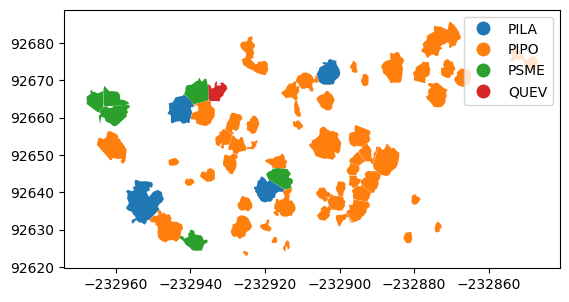

In [4]:
# Load the data
gdf = gpd.read_file(LABELS_FILENAME)

gdf.query(f"fire=='{short_model_name}'").plot(
    LABELS_COLUMN, legend=True, vmin=0, vmax=9
)

# Load the mesh and read texture from geopolygon

In [5]:
# Create a labeled version of the mesh from the field data
# if not present or requested
if not Path(LABELED_MESH_FILENAME).is_file() or RETEXTURE:
    # Load the downsampled mesh and apply the texture from the vector file
    mesh = TexturedPhotogrammetryMesh(
        MESH_FILENAME,
        downsample_target=DOWNSAMPLE_TARGET,
        ROI=LABELS_FILENAME,
        ROI_buffer_meters=BUFFER_RADIUS_METERS,
        texture=LABELS_FILENAME,
        texture_column_name=LABELS_COLUMN,
        transform_filename=CAMERAS_FILENAME,
    )
    # Label the ground class
    mesh.label_ground_class(
        DTM_file=DTM_FILE,
        height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
        only_label_existing_labels=True,
        ground_class_name="ground",
        set_mesh_texture=True,
    )

    mesh.save_mesh(LABELED_MESH_FILENAME, save_vert_texture=True)
else:
    mesh = TexturedPhotogrammetryMesh(
        LABELED_MESH_FILENAME, transform_filename=CAMERAS_FILENAME
    )
class_names = mesh.get_label_names()
print(f"IDs to labels: {mesh.IDs_to_labels}")

Loading transform to EPSG:4326
Loading mesh
Reading the mesh


Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI
Extracting points from pyvista mesh
Extraction surface from subset mesh
Extracting faces from mesh
Loading texture
Could not read texture as a scalar from the pyvista mesh
Could not read texture as a numpy file


Sampling values from raster /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/valley/02_photogrammetry/exports/dtms/valley.tif: 100%|██████████| 134102/134102 [00:05<00:00, 23682.92it/s]

This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices
IDs to labels: {0: 'ABCO', 1: 'CADE', 2: 'PILA', 3: 'PIPO', 4: 'PSME', 5: 'QUEV', 6: 'SNAG', 7: 'ground'}


# Load a set of cameras and downsample them to the region around annotations

Loading GPS data for camera set: 100%|██████████| 9452/9452 [00:00<00:00, 2120823.91it/s]
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/plotting/plotter.py:149: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


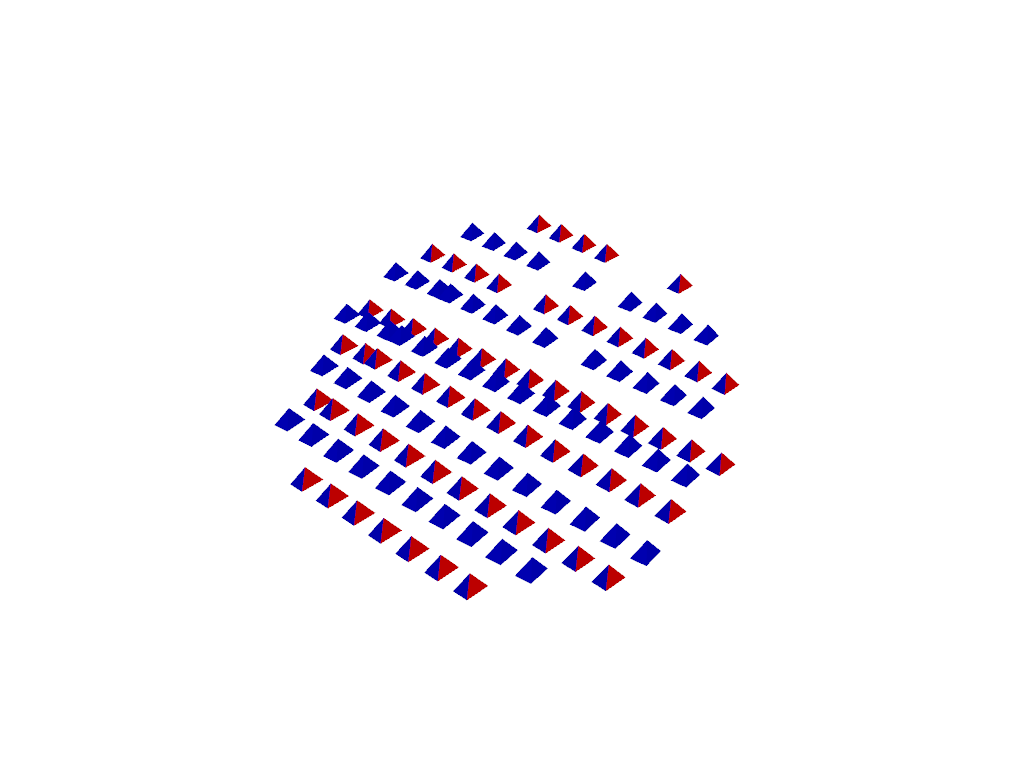

In [6]:
# Create camera set
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_ROI(
    ROI=LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METERS
)
training_camera_set.vis(force_xvfb=True, frustum_scale=0.5)

# Show the mesh

This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


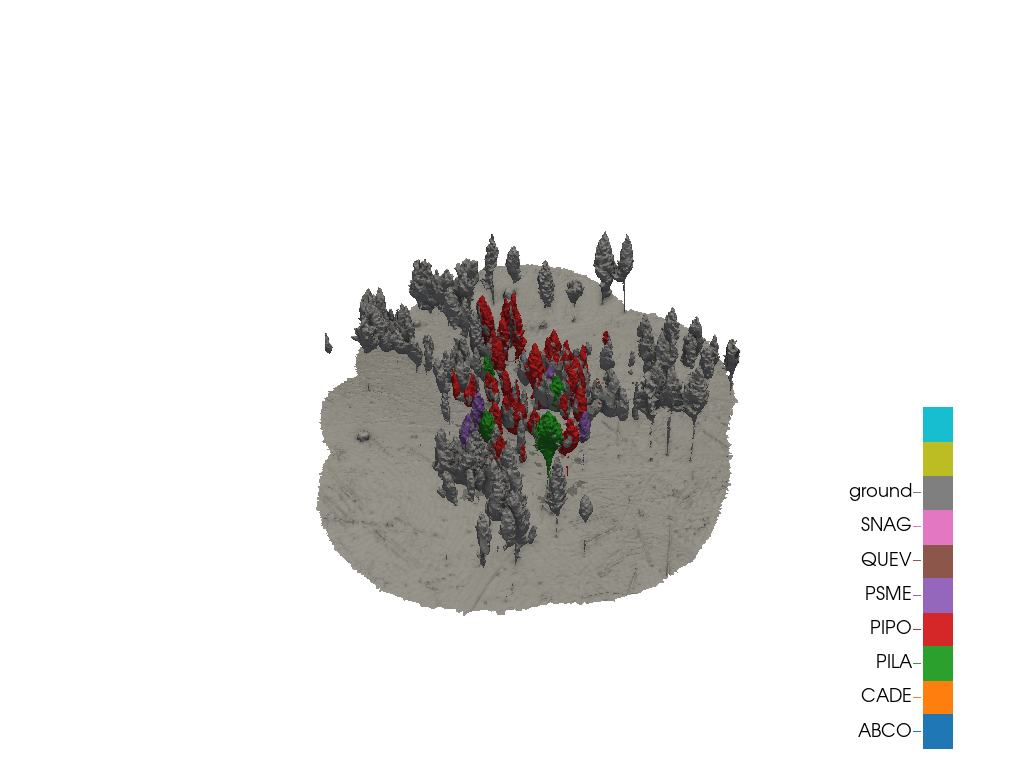

In [7]:
# You can include the camera set, but it's cleaner without it
mesh.vis(camera_set=None, force_xvfb=True)

# Render the labels onto the images

In [8]:
mesh.save_renders_pytorch3d(
    camera_set=training_camera_set,
    render_image_scale=RENDER_IMAGE_SCALE,
    save_native_resolution=True,
    output_folder=RENDER_FOLDER,
)

Saving renders to /home/russelldj/scratch/organized_str_disp_MVMT_experiments/per_site_processing/valley/03_training_data/renders
Saving IDs_to_labels to /home/russelldj/scratch/organized_str_disp_MVMT_experiments/per_site_processing/valley/03_training_data/renders/IDs_to_labels.json


Saving renders: 100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


# Show some of the rendered labels

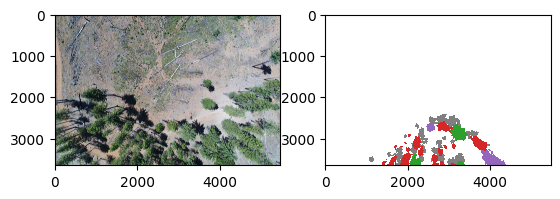

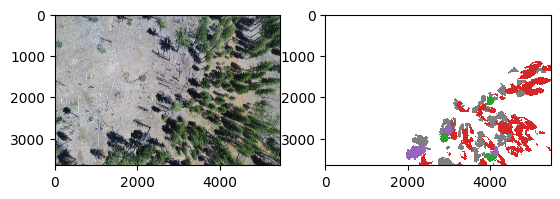

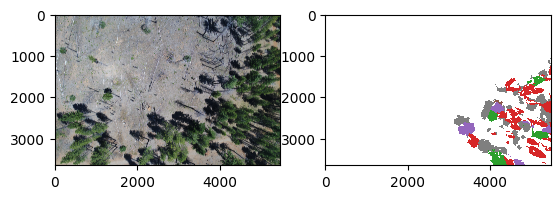

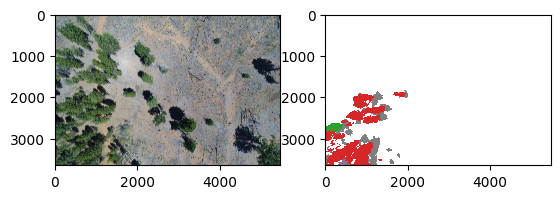

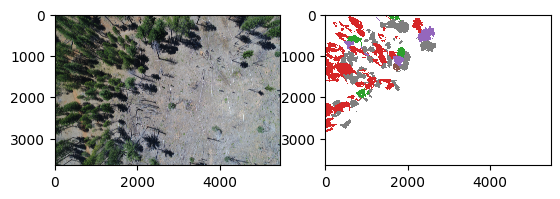

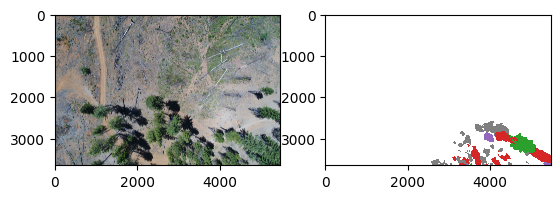

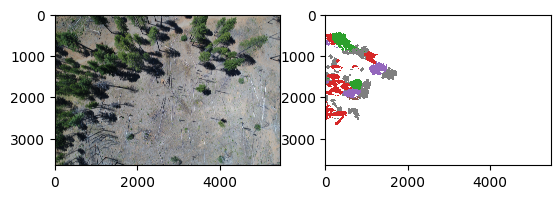

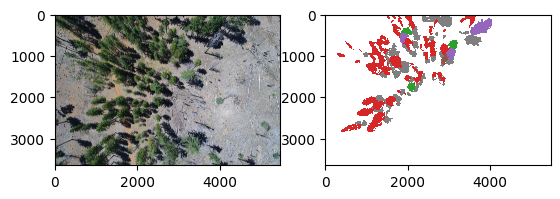

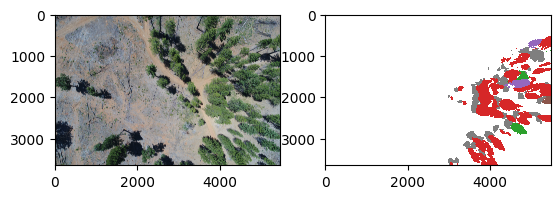

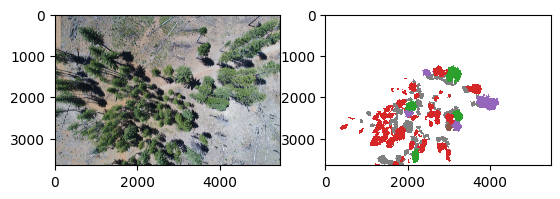

In [9]:
show_segmentation_labels(label_folder=RENDER_FOLDER, image_folder=IMAGE_FOLDER)

# Copy files from scratch

In [11]:
shutil.copytree(src=RENDER_FOLDER_SCRATCH, dst=RENDER_FOLDER,dirs_exist_ok=True)

/home/russelldj/scratch/organized_str_disp_MVMT_experiments
/ofo-share/scratch-david/organized-str-disp-MVMT-experiments


Error: ['<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '2', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '2', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '3', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '3', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '9', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '9', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '4', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '4', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '7', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '7', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '7', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '7', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '0', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '0', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '3', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '3', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '1', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '1', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '6', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '6', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '6', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '6', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '7', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '7', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '6', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '6', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '4', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '4', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '1', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '1', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '5', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '5', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '9', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '9', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '4', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '4', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '0', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 'v', 'a', 'l', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '0', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '2', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '2', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '2', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '2', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '7', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '7', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '6', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '6', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '0', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '0', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '0', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '0', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '6', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '6', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '0', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '0', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '2', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '2', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '5', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '5', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '9', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '9', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '0', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '0', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '0', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '0', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '9', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '9', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '9', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '9', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '0', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '0', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '5', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '5', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '4', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '4', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '5', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '5', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '1', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '1', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '3', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '3', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '2', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '2', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '9', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '9', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '1', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '1', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '1', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '1', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '7', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '7', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '2', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '2', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '6', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '6', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '0', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '0', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '1', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '1', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '0', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '0', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '7', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '7', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '4', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '4', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '7', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '7', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '4', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '4', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '3', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '3', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '3', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '3', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '8', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '8', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '0', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '0', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '8', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '8', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '3', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '3', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '8', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '8', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '9', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '9', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '6', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '6', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '4', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '4', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '7', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '7', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '3', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '3', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '7', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '7', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '6', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '6', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '3', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '3', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '1', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '1', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '4', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '4', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '1', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '1', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '7', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '7', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '3', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '3', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '2', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '2', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '0', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '0', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '0', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '0', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '4', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '4', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '6', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '6', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '0', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '0', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '3', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '3', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '3', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '3', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '6', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '6', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '3', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '3', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '7', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '7', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '3', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '3', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '6', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '6', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '8', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '8', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '9', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '9', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '6', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '6', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '0', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '0', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '7', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '7', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '6', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '6', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '6', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '6', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '4', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '4', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '6', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '6', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '0', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '0', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '2', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '2', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '2', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '2', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '0', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '0', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '2', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '2', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '5', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '5', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '3', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '3', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '6', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '6', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '6', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '6', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '4', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '4', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '7', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '7', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '1', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '1', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '6', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '6', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '4', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '4', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '4', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '4', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '7', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '7', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '1', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '1', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '0', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '0', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '3', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '3', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '6', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '6', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '6', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '6', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '9', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '9', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '4', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '4', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '0', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '0', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '9', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '9', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '6', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '6', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '7', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '7', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '1', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '1', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '0', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '0', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '3', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '3', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '9', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '9', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '3', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '3', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '3', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '3', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '5', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '5', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '3', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '3', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '7', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '7', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '4', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '4', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '1', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '1', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '4', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '4', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '8', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '8', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '0', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '0', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '9', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '9', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '6', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '6', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '1', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '1', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '1', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '1', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '9', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '9', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '1', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '1', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '2', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '2', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '4', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '4', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '2', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '2', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '7', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '7', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '3', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '3', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '3', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '3', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '7', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '7', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '1', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '1', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '0', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '0', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '6', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '6', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '9', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '9', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '5', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '5', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '0', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '0', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '4', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '4', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '1', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '1', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '3', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '3', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '7', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '7', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '1', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '1', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '3', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '3', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '3', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '3', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '9', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '9', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '0', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '0', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '7', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '7', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '1', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '1', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '6', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '6', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '0', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '0', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '8', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '8', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '7', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '7', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '2', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '2', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '4', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '4', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '6', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '6', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '0', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '0', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '3', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '3', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '2', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '2', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '5', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '5', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '0', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '0', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '6', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '6', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '2', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '2', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '2', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '2', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '2', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '2', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '7', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '7', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '1', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '1', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '3', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '3', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '7', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '7', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '9', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '9', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '2', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '2', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '0', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '0', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '8', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '8', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '2', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '2', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '7', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '7', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '2', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '2', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '4', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '4', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '3', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '3', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '3', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '3', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '2', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '2', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '1', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '1', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '7', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '7', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '7', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '7', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '9', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '9', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '7', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '7', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '0', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '0', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '4', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '4', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '4', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '4', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '2', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '2', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '2', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '2', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '1', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '1', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '2', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '2', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '1', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '1', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '4', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '7', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '7', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '1', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '1', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '2', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '2', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '9', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '9', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '8', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '8', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '7', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '7', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '1', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '1', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '0', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '0', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '3', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '3', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '0', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '0', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '4', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '4', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '5', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '5', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '1', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '1', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '0', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '0', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '1', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '1', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '4', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '4', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '3', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '3', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '0', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '0', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '4', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '4', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '8', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '8', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '5', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '5', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '7', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '7', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '3', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '3', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '3', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '3', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '3', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '3', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '3', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '3', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '5', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '3', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '0', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '0', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '6', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '6', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '4', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '4', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '7', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '7', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '5', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '5', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '2', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '2', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '7', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '7', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '6', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '6', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '5', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '5', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '7', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '7', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '9', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '4', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '4', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '1', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '1', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '5', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '6', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '0', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '0', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '2', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '2', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '0', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '0', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '1', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '3', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '3', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '4', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '6', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '2', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '2', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '2', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '2', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '6', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '6', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '5', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '1', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '1', '1', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '9', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '8', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '3', '8', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '5', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '5', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '2', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '2', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '0', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '0', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '9', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '2', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '0', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '8', '0', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '6', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '6', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '5', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '8', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '5', '8', '9', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '3', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '6', '4', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '0', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '0', '7', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '8', '8', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '9', '1', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '4', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '0', '2', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '3', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '9', '5', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '4', '8', '5', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '1', '2', '0', 'm', '_', 'P', 'A', 'R', 'T', '_', '0', '2', '_', '1', '0', '1', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '7', '1', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '9', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '6', '_', '1', '0', '0', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '2', '9', '6', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e', '<', 'D', 'i', 'r', 'E', 'n', 't', 'r', 'y', ' ', "'", 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '6', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", '>', ' ', 'a', 'n', 'd', ' ', "'", '/', 'o', 'f', 'o', '-', 's', 'h', 'a', 'r', 'e', '/', 's', 'c', 'r', 'a', 't', 'c', 'h', '-', 'd', 'a', 'v', 'i', 'd', '/', 'o', 'r', 'g', 'a', 'n', 'i', 'z', 'e', 'd', '-', 's', 't', 'r', '-', 'd', 'i', 's', 'p', '-', 'M', 'V', 'M', 'T', '-', 'e', 'x', 'p', 'e', 'r', 'i', 'm', 'e', 'n', 't', 's', '/', 'p', 'e', 'r', '_', 's', 'i', 't', 'e', '_', 'p', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', '/', 'c', 'h', 'i', 'p', 's', '/', '0', '3', '_', 't', 'r', 'a', 'i', 'n', 'i', 'n', 'g', '_', 'd', 'a', 't', 'a', '/', 'c', 'h', 'i', 'p', 's', '_', '8', '0', 'm', '_', 'o', 'n', 'l', 'y', '_', 'n', 'o', '_', 'g', 'r', 'o', 'u', 'n', 'd', '/', 'i', 'm', 'g', '_', 'd', 'i', 'r', '/', 't', 'r', 'a', 'i', 'n', '/', 'C', 'h', 'i', 'p', 's', 'B', '_', '8', '0', 'm', '_', '2', '0', '2', '1', '_', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', '_', 'S', 'D', '_', 'c', 'a', 'r', 'd', '_', '2', '5', '_', '1', '0', '4', 'M', 'E', 'D', 'I', 'A', '_', 'D', 'J', 'I', '_', '0', '0', '6', '0', '_', 'r', 'g', 'b', '.', 'J', 'P', 'G', "'", ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 's', 'a', 'm', 'e', ' ', 'f', 'i', 'l', 'e']